# Linear Models

Principle : Linear models make a prediction using a linear function of the input features. Each feature is assigned a weight learned by the algorithm.
There are many different linear models for classification. The difference between these models lies in how the model parameters w and b are learned from the training data, and how model complexity can be controlled. The two most common algorithms are *logistic regression* (despites its name) and *linear support vector machines*.
For both of them, the regularization parameter C can be adjusted to get better results. The higher the value, the most the algorithm is gonna give importance to every points for the dataset trying to fit as most as possible to the training set. Using low values means the algorithm is gonna try to adjust to the "majority" of the points.

### Set up

First import all necessary packages in order not to worry about them when testing new parameters/algorithms:

In [ ]:
%load_ext autoreload
%autoreload
from LinearModels import display_plot_logreg, display_plot_svc
from utils import feature_selection, thomas_parser

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

## Logistic Regression

### First test

Let's try the logistic regression first with C set to the default value 1, then C=100 and eventually C=0.01.

In [3]:
gt = pd.read_csv('../dumps/2020.01.13-14.25.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

logreg = LogisticRegression(max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

Training set score: 0.839
Test set score: 0.774


In [4]:
logreg100 = LogisticRegression(C=100,max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg100.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg100.score(data_test, target_test)))

Training set score: 0.839
Test set score: 0.779


In [5]:
logreg001 = LogisticRegression(C=0.01,max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg001.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg001.score(data_test, target_test)))

Training set score: 0.838
Test set score: 0.779


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


An error is raised saying that the classifier failed to converge, which is probably related to the value we chose for C. In order to solve this issue, we have three solutions : increase the number of iterations (already done), change C value (purpose of this case) or eventually normalize the data around a mean of 0. Let's try the last one :

In [9]:
data_scaled = preprocessing.scale(data_train)
target_scaled = preprocessing.scale(target_train)
logreg001 = LogisticRegression(C=0.01,max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg001.score(data_train, target_train)))

Training set score: 0.838


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Even in this case we cannot reach a convergence point. We can therefore conclude that a value of C=0.01 is not suited for this dataset.
For the two first ones, it's intersting to notice that the values are always quite similar.

### Further tests

#### Regularization parameter

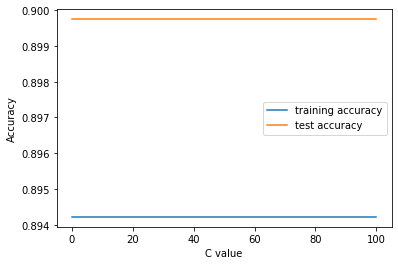

In [24]:
display_plot_logreg('../dumps/2020.02.10-12.14.csv',0.20,0.01,100)

### Best match

In [12]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

In [13]:
parameters = {'C': [0.01,0.1, 1, 10, 100], 'max_iter':[100,1000,10000]}
clf = GridSearchCV(LogisticRegression(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

0.8942172073342737
{'C': 0.01, 'max_iter': 100}
0.899749373433584
{'C': 0.01, 'max_iter': 100}


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [14]:
parameters = {'C': [0.01,0.1, 1, 10, 100], 'max_iter':[100,1000,10000]}
clf = RandomizedSearchCV(LogisticRegression(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

0.8942172073342737
{'max_iter': 100, 'C': 1}
0.899749373433584
{'max_iter': 100, 'C': 1}


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Features relevance

Here below we will follow an iterative process in order to select the most relevant features of our model. The way it works is as follow : first we start a small training set, measure the accuracy and select the most relevant features using *SelectFromModel*. Then we apply the same reasoning on a slightly larger training set. Between two iterations, the set of features that is kept is the intersection between the current best features and the previous ones.

In [11]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
raw_data = gt[cols]
raw_target = gt['label']

First step, we start with a training set of 20% of the whole dataset.

In [17]:
#Computing initial accuracies without tuning
data_train, data_test, target_train, target_test = train_test_split(raw_data, raw_target, test_size = 0.85, random_state = 0)
print(data_train.shape)
logreg = LogisticRegression(C=1, max_iter=10000)
logreg.fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

#Select best features
model = SelectFromModel(logreg, prefit=True)
train_new = model.transform(data_train)
print(train_new.shape)
mask = model.get_support()
A_set = data_train.columns[mask]

#Creating new dataset with only wanted features and computing new accuracies
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
data = gt[A_set]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.85, random_state = 0)
logreg.fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

(1196, 119)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training set score: 0.898
Test set score: 0.845
(1196, 8)
Training set score: 0.889
Test set score: 0.897


We now increase the size of the training set.

In [18]:
#Computing initial accuracies without tuning
data_train, data_test, target_train, target_test = train_test_split(raw_data, raw_target, test_size = 0.70, random_state = 0)
print(data_train.shape)
logreg = LogisticRegression(C=1, max_iter=10000)
logreg.fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

#Select best features
model = SelectFromModel(logreg, prefit=True)
train_new = model.transform(data_train)
print(train_new.shape)
mask = model.get_support()
B_set = data_train.columns[mask]

#Creating new dataset with only wanted features and computing new accuracies
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
data = gt[B_set]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.70, random_state = 0)
logreg.fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

#Creating new dataset with A's best features and computing new accuracies
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
data = gt[A_set]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.70, random_state = 0)
logreg.fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

#Intersection of two subsets with the best features
C_set = [value for value in B_set if value in A_set]

(2393, 119)
Training set score: 0.895
Test set score: 0.886
(2393, 5)
Training set score: 0.901
Test set score: 0.894
Training set score: 0.897
Test set score: 0.889


We now carry on repeating the same process : increasing the training set, finding the best features and the intersection with the previous set until convergence.

0.15
(1196, 119)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(1196, 8)
0.3
(2393, 119)
(2393, 5)
3
0.44999999999999996
(3589, 119)
(3589, 37)
2
0.6
(4786, 119)
(4786, 40)
2
0.75
(5982, 119)
(5982, 49)
2
0.9
(7179, 119)
(7179, 58)
2


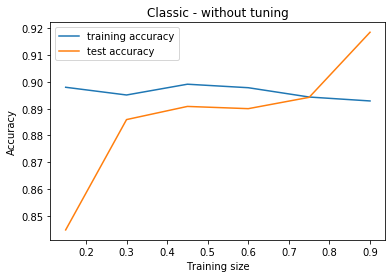

Training max value : 0.8991362496517136
Test max value : 0.918546365914787


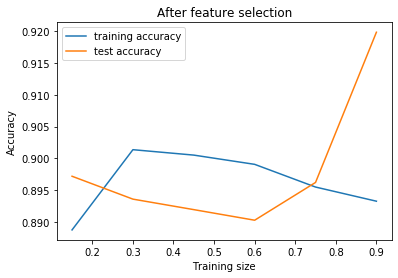

Training max value : 0.9013790221479314
Test max value : 0.9197994987468672


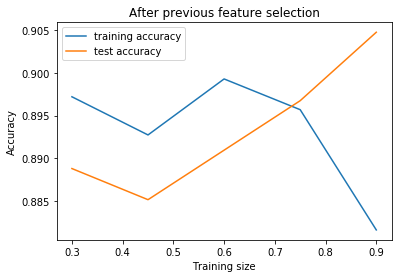

Training max value : 0.8992895946510656
Test max value : 0.9047619047619048


In [16]:
feature_selection('../dumps/2020.02.10-12.14.csv', 0.15, "log")

We get the best results when applying feature selection indepedently from the previous results we get on smaller training sets.

Let's, once more, try the feature extraction on a dataset of 14K samples and see how the performances are impacted.

0.15
(2205, 119)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(2205, 38)
0.3
(4410, 119)
(4410, 9)
8
0.44999999999999996
(6616, 119)
(6616, 12)
8
0.6
(8821, 119)
(8821, 35)
8
0.75
(11027, 119)
(11027, 34)
8
0.9
(13232, 119)
(13232, 28)
8


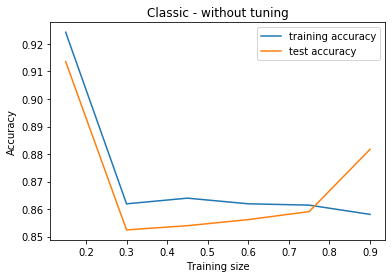

Training max value : 0.9242630385487528
Test max value : 0.913586173787806


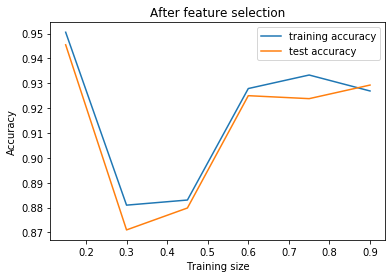

Training max value : 0.9505668934240363
Test max value : 0.9455112818050888


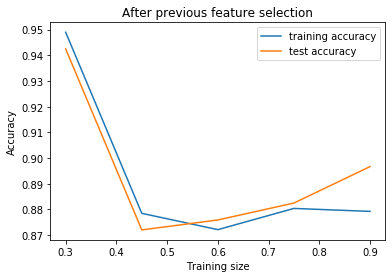

Training max value : 0.9489795918367347
Test max value : 0.9424851841057029


In [2]:
feature_selection('../dumps/2020.03.11-17.39.csv',0.15,"log")

We can observe that after the second iteration and until the end, the 8 same features are always selected for the last case. This is quite strange because the accuracies they offer are worse than first one, which I guess mean that 8 features is not enough in this case to get great performances, as opposed to the second graph where the results are better after this iteration.
It's also interesting to notice that in the case of the feature extraction, we obtain better stats but not with the original complete feature set. Increasing the dataset did introduce even more volatility in the different values and hardened the convergence.

## Linear SVC

### First test

Same procedure as done before with logistic regression where a first test is made with C value set to 1, 100 and 0.01.

In [22]:
gt = pd.read_csv('../dumps/2020.01.13-14.25.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

In [23]:
linsvc = LinearSVC(max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(linsvc.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(linsvc.score(data_test, target_test)))

Training set score: 0.740
Test set score: 0.698


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [24]:
linsvc100 = LinearSVC(C=100,max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(linsvc100.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(linsvc100.score(data_test, target_test)))

Training set score: 0.730
Test set score: 0.653


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [26]:
linsvc001 = LinearSVC(C=0.01,max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(linsvc001.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(linsvc001.score(data_test, target_test)))

Training set score: 0.779
Test set score: 0.754


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Here again, we can see that we suffer from convergence failure.

### Further tests

### Regularization parameter

/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


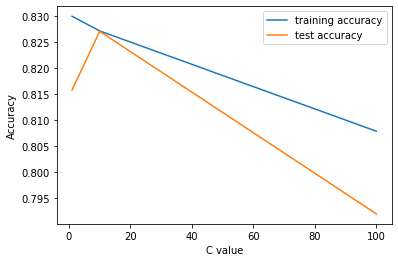

In [15]:
display_plot_svc('../dumps/2020.02.10-12.14.csv',0.20,1,100)

### Best match

In [3]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

In [15]:
parameters = {'C': [0.01,0.1, 1, 10, 100], 'max_iter':[100,1000,10000]}
clf = GridSearchCV(LinearSVC(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

0.7967403228334117
{'C': 0.01, 'max_iter': 100}
0.7894736842105263
{'C': 0.01, 'max_iter': 100}


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [16]:
parameters = {'C': [0.01,0.1, 1, 10, 100], 'max_iter':[100,1000,10000]}
clf = RandomizedSearchCV(LinearSVC(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

0.7490988873217364
{'max_iter': 1000, 'C': 0.1}
0.7543859649122807
{'max_iter': 1000, 'C': 0.1}


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Features relevance

See LinearRegression in order to understand which processus we follow to generate the values.

0.15
(1196, 119)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(1196, 9)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.3
(2393, 119)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(2393, 6)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


3
0.44999999999999996
(3589, 119)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(3589, 38)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


2
0.6
(4786, 119)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(4786, 42)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


1
0.75
(5982, 119)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(5982, 52)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


1
0.9
(7179, 119)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(7179, 49)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


1


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


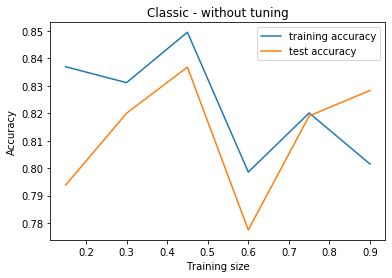

Training max value : 0.849540261911396
Test max value : 0.8368277119416591


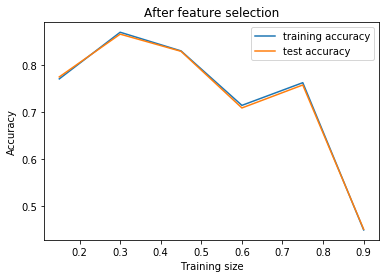

Training max value : 0.8704554951943168
Test max value : 0.8664040114613181


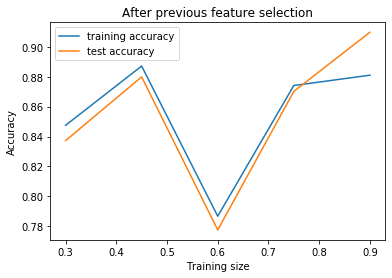

Training max value : 0.8871551964335469
Test max value : 0.9097744360902256


In [28]:
feature_selection('../dumps/2020.02.10-12.14.csv', 0.15, "svc")

The results here are different that the other linear algorithm. We have multiple drops at different intervals and the best value we get is when considering the intersection of all the best features.

Let's also test with the bigger dataset of 14k samples.

0.15
(2205, 119)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(2205, 45)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.3
(4410, 119)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(4410, 40)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


25
0.44999999999999996
(6616, 119)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(6616, 48)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


20
0.6
(8821, 119)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(8821, 43)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


15
0.75
(11027, 119)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(11027, 44)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


15
0.9
(13232, 119)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(13232, 47)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


11


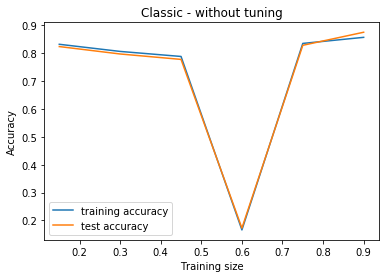

Training max value : 0.8566354292623942
Test max value : 0.8749150237933379


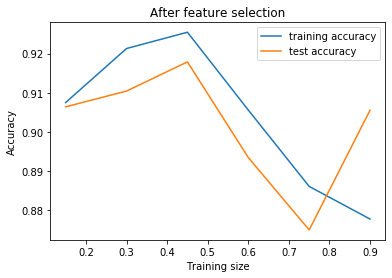

Training max value : 0.9254836759371221
Test max value : 0.9178929145542228


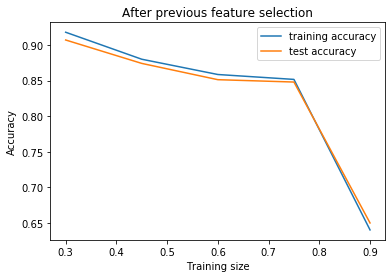

Training max value : 0.9179138321995465
Test max value : 0.9070241911979015


In [3]:
feature_selection('../dumps/2020.03.11-17.39.csv',0.15,"svc")

What we can notice:
    - Accuracies are only slightly improved
    - After some point, the set of best features selected is constant
    - Performances degrade when increasing the training set for 2 out of 3 cases
    - We can observe a huge drop when performing natural training (probably because the values added are extremely sparse)
    - Performances for feature intersection is particularily bad (probably, once again, because the model cannot be reduced to only these few features and the weights are hard to guess)

### Test on Thomas datasets

In [5]:
gt = pd.read_csv("../dumps/2019-08.Merged_thomas.csv")
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

tree = LogisticRegression(C=1, max_iter=10000,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.778
Accuracy on test set: 0.769


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
gt = pd.read_csv("../dumps/2019-09.Merged_thomas.csv")
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

tree = LinearSVC(C=0.1, max_iter=10000,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

In [ ]:
gt = pd.read_csv("../dumps/2019-08.Merged_thomas.csv")
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

tree = LinearSVC(C=0.1, max_iter=10000,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

In [ ]:
gt = pd.read_csv("../dumps/2019-09.Merged_thomas.csv")
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

tree = LinearSVC(C=0.1, max_iter=10000,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))